<a href="https://colab.research.google.com/github/ProstoRav/Netology/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D1%82%D0%B5%D0%BC%D0%B5_%C2%AB%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Загрузка данных
births = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Netology/4. Временные ряды/Лекция_tsml + ДЗ/Series/daily-total-female-births-in-cal.csv')
sales  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Netology/4. Временные ряды/Лекция_tsml + ДЗ/Series/monthly-sales-of-company-x-jan-6.csv')

In [3]:
# Приведение данных к временному индексу
births['Date'] = pd.to_datetime(births['Date'])
births = births.set_index('Date').asfreq('D')
y_births = births['Count'].astype(float)

sales['Month'] = pd.to_datetime(sales['Month'])
sales = sales.set_index('Month').asfreq('MS')
y_sales = sales['Count'].astype(float)

In [4]:
# Тест Дики–Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    )
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Визуализация графиков
def tsplot(y, name, lags=None, figsize=rcParams['figure.figsize'], style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax  = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax= plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='Green', label='Original')
        ts_ax.set_title(name)
        ts_ax.legend(loc='upper left')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')

        plt.tight_layout()

##Обзор временных рядов для эксперимента

1) daily-total-female-births-in-cal.csv

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


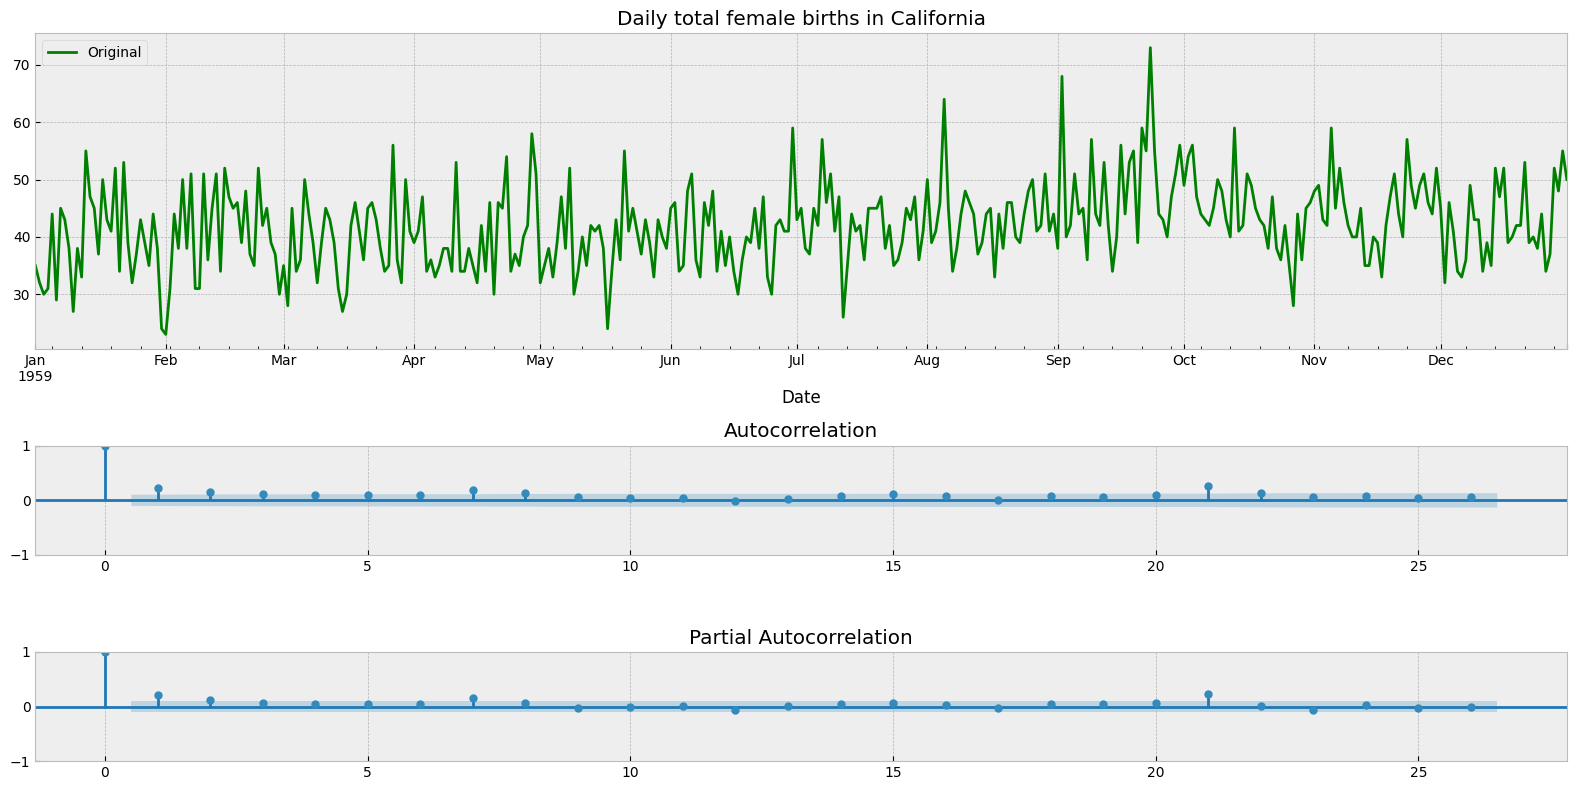

In [5]:
tsplot(y_births, "Daily total female births in California")

По тесту Дики–Фуллера и по виду графика ряд можно рассматривать как близкий к стационарному.

2) monthly-sales-of-company-x-jan-6.csv

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


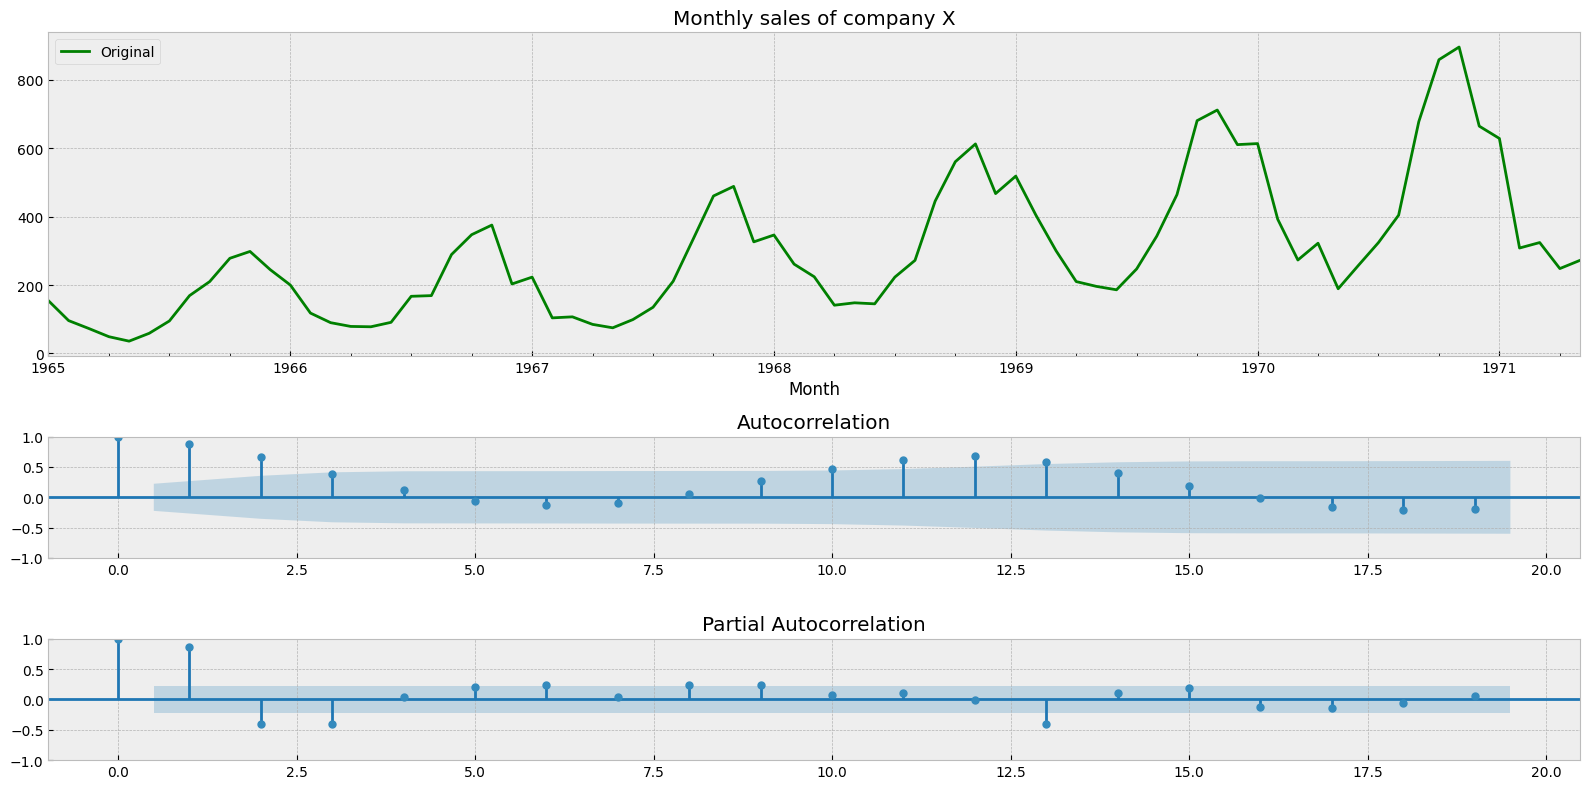

In [6]:
tsplot(y_sales, "Monthly sales of company X")

Ряд продаж имеет ярко выраженную нестационарность (временное изменение/тренд).

## Обзор моделей класса MA: MA, EMA, DEMA, TEMA

Ниже описаны 4 метода сглаживания/прогнозирования:

- **MA (SMA)**: прогноз = среднее последних *N* наблюдений.
- **EMA**: экспоненциальное сглаживание (больший вес последним наблюдениям).
- **DEMA**: уменьшает лаг EMA: `DEMA = 2*EMA1 - EMA2`, где `EMA2 = EMA(EMA1)`.
- **TEMA**: ещё сильнее уменьшает лаг: `TEMA = 3*EMA1 - 3*EMA2 + EMA3`, где `EMA3 = EMA(EMA2)`.

Для оценки используется пошаговый (*walk-forward*) прогноз: на каждом шаге предсказывается
следующее значение, используя только прошлое фактическое.


In [7]:
# Описываем модели функциями

def span_to_alpha(span: int) -> float:
    return 2.0 / (span + 1.0)

def wf_forecast_ma(history, horizon, window: int):
    hist = list(history)
    preds = []
    for y_true in horizon:
        if len(hist) < window:
            preds.append(np.mean(hist))
        else:
            preds.append(np.mean(hist[-window:]))
        hist.append(y_true)
    return np.array(preds)

def wf_forecast_ema(history, horizon, span: int):
    alpha = span_to_alpha(span)
    hist = list(history)

    s = hist[0]
    for x in hist[1:]:
        s = alpha * x + (1 - alpha) * s

    preds = []
    for y_true in horizon:
        preds.append(s)
        s = alpha * y_true + (1 - alpha) * s
    return np.array(preds)

def wf_forecast_dema(history, horizon, span: int):
    alpha = span_to_alpha(span)
    hist = list(history)

    ema1 = hist[0]
    ema2 = ema1
    for x in hist[1:]:
        ema1 = alpha * x + (1 - alpha) * ema1
        ema2 = alpha * ema1 + (1 - alpha) * ema2

    preds = []
    for y_true in horizon:
        dema = 2 * ema1 - ema2
        preds.append(dema)
        ema1 = alpha * y_true + (1 - alpha) * ema1
        ema2 = alpha * ema1 + (1 - alpha) * ema2
    return np.array(preds)

def wf_forecast_tema(history, horizon, span: int):
    alpha = span_to_alpha(span)
    hist = list(history)

    ema1 = hist[0]
    ema2 = ema1
    ema3 = ema2
    for x in hist[1:]:
        ema1 = alpha * x + (1 - alpha) * ema1
        ema2 = alpha * ema1 + (1 - alpha) * ema2
        ema3 = alpha * ema2 + (1 - alpha) * ema3

    preds = []
    for y_true in horizon:
        tema = 3 * ema1 - 3 * ema2 + ema3
        preds.append(tema)
        ema1 = alpha * y_true + (1 - alpha) * ema1
        ema2 = alpha * ema1 + (1 - alpha) * ema2
        ema3 = alpha * ema2 + (1 - alpha) * ema3
    return np.array(preds)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

## Схема подбора параметров и оценка качества

Для каждого ряда:
1. Делим данные на 3 части:
   - **train_init**: первая часть ряда (подбор параметров),
   - **val**: следующий отрезок (валидация для выбора параметров),
   - **test**: последний отрезок (финальная проверка).
2. Подбираем параметр (окно/период) по минимальному RMSE на валидации.
3. С выбранным параметром строим прогноз на тесте и сравниваем модели по RMSE.


In [8]:
# Функция для пункта 1
def split_series(y: pd.Series, test_size: int, val_size: int):
    y = y.dropna()
    test = y.iloc[-test_size:]
    rest = y.iloc[:-test_size]
    val = rest.iloc[-val_size:]
    train_init = rest.iloc[:-val_size]
    return train_init, val, test

# Функция для пункта 2 и 3
def tune_and_evaluate(y: pd.Series, test_size: int, val_size: int,
                      ma_windows, spans):
    train_init, val, test = split_series(y, test_size=test_size, val_size=val_size)

    best = {}

    # MA
    best_rmse = float('inf')
    best_w = None
    for w in ma_windows:
        preds = wf_forecast_ma(train_init.values, val.values, window=w)
        score = rmse(val.values, preds)
        if score < best_rmse:
            best_rmse, best_w = score, w
    best['MA'] = {'param': best_w, 'val_rmse': best_rmse}

    # EMA / DEMA / TEMA
    for name, fn in [('EMA', wf_forecast_ema), ('DEMA', wf_forecast_dema), ('TEMA', wf_forecast_tema)]:
        best_rmse = float('inf')
        best_span = None
        for s in spans:
            preds = fn(train_init.values, val.values, span=s)
            score = rmse(val.values, preds)
            if score < best_rmse:
                best_rmse, best_span = score, s
        best[name] = {'param': best_span, 'val_rmse': best_rmse}

    train_full = pd.concat([train_init, val])

    results = []
    forecasts = {}
    for name, cfg in best.items():
        if name == 'MA':
            preds = wf_forecast_ma(train_full.values, test.values, window=cfg['param'])
        elif name == 'EMA':
            preds = wf_forecast_ema(train_full.values, test.values, span=cfg['param'])
        elif name == 'DEMA':
            preds = wf_forecast_dema(train_full.values, test.values, span=cfg['param'])
        else:
            preds = wf_forecast_tema(train_full.values, test.values, span=cfg['param'])

        score = rmse(test.values, preds)
        results.append([name, cfg['param'], cfg['val_rmse'], score])
        forecasts[name] = preds

    res_df = pd.DataFrame(results, columns=['Model', 'Best_param', 'RMSE_val', 'RMSE_test'])               .sort_values('RMSE_test')
    return train_init, val, test, res_df, forecasts

## Эксперимент со стационарным рядом (daily-total-female-births-in-cal)

In [9]:
# Для ряда оставляем 30 дней на тест, и ещё 30 дней на валидацию
train_b, val_b, test_b, res_b, fc_b = tune_and_evaluate(
    y_births,
    test_size=30,
    val_size=30,
    ma_windows=list(range(2, 61)),   # окна 2-60 дней
    spans=list(range(2, 61))         # периоды 2-60
)

res_b

,Model,Best_param,RMSE_val,RMSE_test
1,EMA,5,5.889860,7.205618
2,DEMA,7,6.064257,7.440865
3,TEMA,9,6.186078,7.568970
0,MA,4,5.692466,7.587407


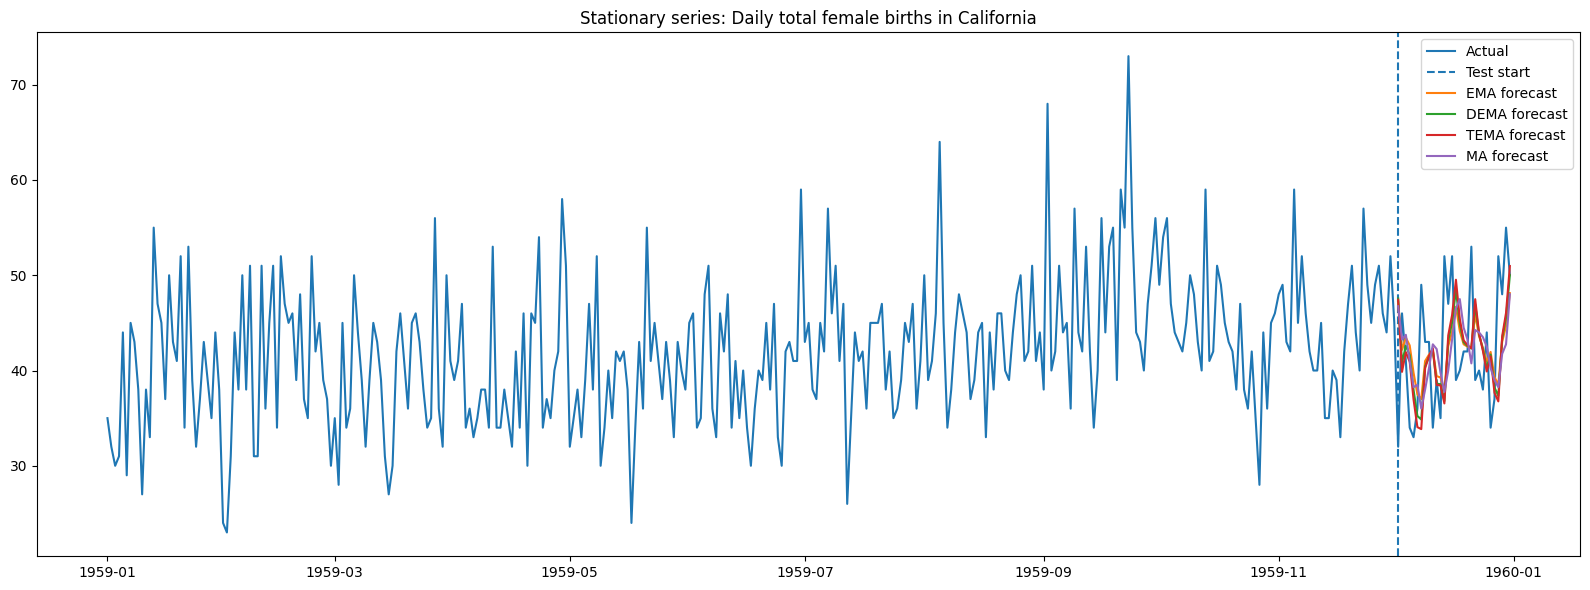

In [10]:
# Визуализация прогнозов на тесте
plt.figure(figsize=(16,6))
plt.plot(y_births.index, y_births.values, label='Actual')
plt.axvline(test_b.index[0], linestyle='--', label='Test start')

for name in res_b['Model'].tolist():
    preds = fc_b[name]
    plt.plot(test_b.index, preds, label=f'{name} forecast')

plt.title("Stationary series: Daily total female births in California")
plt.legend()
plt.tight_layout()
plt.show()

**Оптимальная модель для стационарного ряда.**

In [11]:
best_model_births = res_b.iloc[0].to_dict()
best_model_births

{'Model': 'EMA',
 'Best_param': 5,
 'RMSE_val': 5.889860463396249,
 'RMSE_test': 7.205618102415592}

## Эксперимент с нестационарным рядом (monthly-sales-of-company-x-jan-6)

In [12]:
# Для ряда оставляем 12 месяцев на тест + ещё 12 месяцев на валидацию
train_s, val_s, test_s, res_s, fc_s = tune_and_evaluate(
    y_sales,
    test_size=12,
    val_size=12,
    ma_windows=list(range(2, 25)),   # окна 2-24 месяцев
    spans=list(range(2, 25))         # периоды 2-24
)

res_s

,Model,Best_param,RMSE_val,RMSE_test
3,TEMA,2,118.387693,154.530249
2,DEMA,2,124.091838,162.483645
1,EMA,2,141.700859,182.863895
0,MA,2,148.901813,192.792094


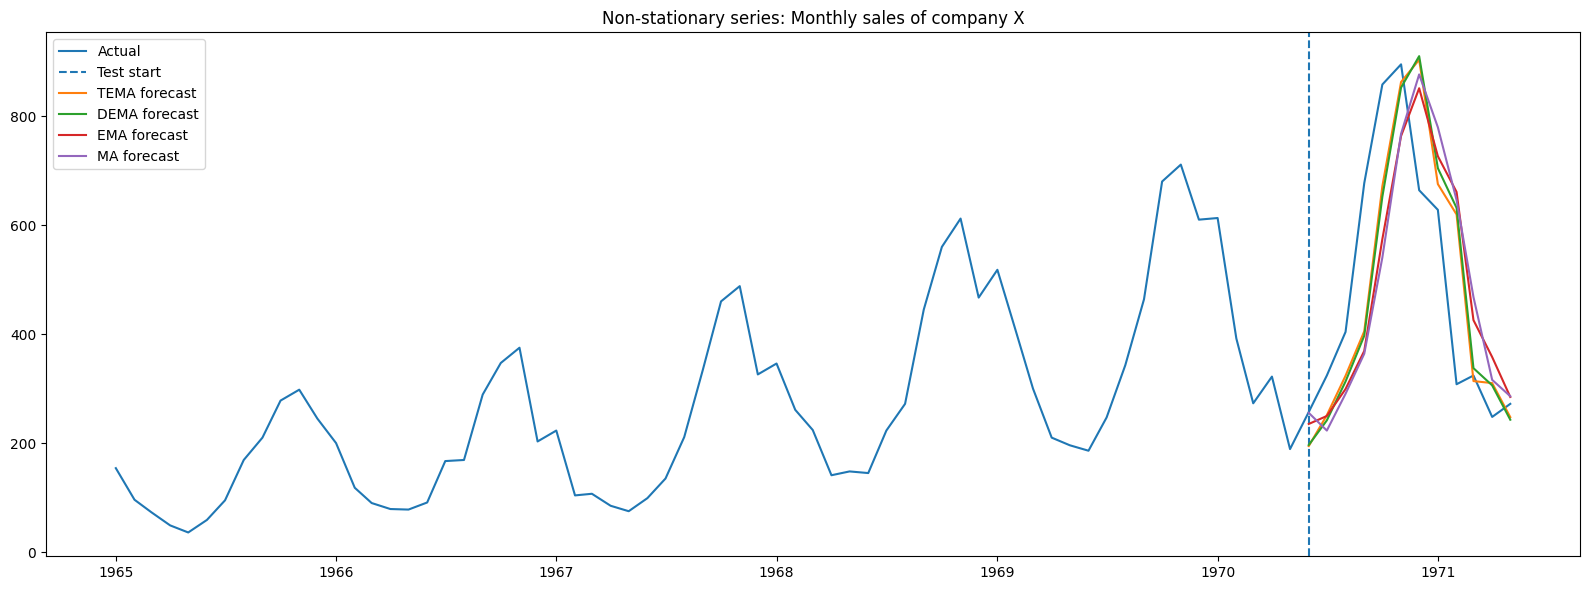

In [13]:
# Визуализация прогнозов на тесте
plt.figure(figsize=(16,6))
plt.plot(y_sales.index, y_sales.values, label='Actual')
plt.axvline(test_s.index[0], linestyle='--', label='Test start')

for name in res_s['Model'].tolist():
    preds = fc_s[name]
    plt.plot(test_s.index, preds, label=f'{name} forecast')

plt.title("Non-stationary series: Monthly sales of company X")
plt.legend()
plt.tight_layout()
plt.show()

**Оптимальная модель для нестационарного ряда.**


In [14]:
best_model_sales = res_s.iloc[0].to_dict()
best_model_sales

{'Model': 'TEMA',
 'Best_param': 2,
 'RMSE_val': 118.38769295550037,
 'RMSE_test': 154.5302490243576}

## Итог:

- Для стационарного ряда чаще выигрывает модель, которая равномернее сглаживает шум.
  Обычно это **MA** (с подбором окна) или **EMA** (с достаточно большим периодом).
- Для нестационарного ряда с трендом или сдвигом уровня чаще выигрывают модели с меньшим лагом,
  такие как **DEMA/TEMA**, потому что они быстрее поспевают за линией тренда.